<a href="https://colab.research.google.com/github/yashuvishnalia/tensorflow-basic-test-code/blob/master/colab_test2_SINfunc_BF_1_5_10_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
os.listdir('/content/gdrive/My Drive/Colab Notebooks/')

['Copy of first_steps_with_tensor_flow.ipynb',
 'Untitled0.ipynb',
 'colab_test0_nifty.ipynb',
 'modified_intraday_2017_niftyAllData4-10.pkl',
 'colab_test1_nifty.ipynb',
 'my_model.h5',
 '8000_model_INFY_30-10.h5',
 'colab_test2_nifty_P_PCT_V.ipynb',
 '8000_model_INFY_1-15.h5',
 'colab_test2_nifty_P_PCT_V_BF-1-1_5-3_10-6_30-10_1-15.ipynb',
 'RunTest0_INFY_ERROR.ipynb',
 'colab_test2_nifty_P_PCT_V_BF-1-15.ipynb',
 'colab_test2_SINfunc_BF-1-15.ipynb']

In [0]:
from __future__ import print_function
import pandas as pd

print(pd.__version__)

0.23.4


In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import LSTM,Dense, Activation,Dropout

# For custom metrics
import keras.backend as K

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn import preprocessing

tf.random.set_random_seed(1)

Using TensorFlow backend.


In [0]:
np.random.random((5,2)).mean()

0.5273049552434165

In [0]:
# callbacks = [
#   # Interrupt training if `val_loss` stops improving for over 2 epochs
#   tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
#   # Write TensorBoard logs to `./logs` directory
#   tf.keras.callbacks.TensorBoard(log_dir='./logs')
# ]


In [0]:
def train(df,batch_size=32,back_step=1,forward_step=1,model=False,n_feature=1,epochs=50):
  print(df.head())

  data_=np.array(df)

  global scaler
  scaler=scaler.fit(data_)
  data = scaler.transform(data_)
  mc = keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True,verbose=1)
  early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',mode='min', verbose=1,patience=100)#,baseline=4.2307e-04,#monitor='val_loss'
# could use early_stop and mc in a list(it will save best model and stop after patience=50)
  callbacks=[early_stop,mc]
  
  def feature_and_label(X=data[:,0:1],y=data[:,0],back_step=1,forward_step=1):
      X_ = np.array([X[i:i+back_step][:] for i in range(len(X)-back_step+1-forward_step)])#index(0-1009)=len1010
      y_ = np.array([y[i+back_step+forward_step-1] 
                     for i in range(len(y)-back_step+1-forward_step)])    
      return X_,y_
  def data_prep(data,back_step=1,forward_step=1,batch_size=32):
      ''' change data_t[:,1:2],data_t[:,0] accordingly '''
      X_,y_ = feature_and_label(X=data[:,0:1],y=data[:,0],back_step=back_step,forward_step=forward_step)
      X_=X_.reshape(len(X_),len(X_[0]),len(X_[0][0]))
      y_=y_.reshape(len(y_),1)#have to change if we have other dimen of y
      print("shape X, y : ",X_.shape,y_.shape,X_[0],y_[0])

      m=int(len(X_)/batch_size)
      ratio=(int(m*0.8))*batch_size
      ratio1=(int(m*0.9))*batch_size
      train_X,val_X,test_X=X_[:ratio],X_[ratio:ratio1],X_[ratio1:m*batch_size]
      train_y,val_y,test_y=y_[:ratio],y_[ratio:ratio1],y_[ratio1:m*batch_size]
      print("test x,y and train x, y shape : ",test_X.shape,test_y.shape,train_X.shape,train_y.shape)

      return train_X,train_y,test_X,test_y,val_X,val_y

  train_X,train_y,test_X,test_y,val_X,val_y = \
  data_prep(data=data,back_step=back_step,forward_step=forward_step,batch_size=batch_size)
  
  print('train_X[:10],train_y[:10] : ',train_X[:10],train_y[:10] )
  
  def build_neural_net(batch_size,back_step=1,n_feature=1):
    # expected input data shape: (batch_size, timesteps, data_dim)
    model = Sequential()
    model.add(LSTM(128, return_sequences=True,batch_input_shape=(batch_size,back_step, n_feature),
                   stateful=True,))
    model.add(Dropout(0.1))
    model.add(LSTM(256))
    model.add(Dropout(0.1))
    model.add(Dense(64))
    model.add(Dense(1))
    # For a mean squared error regression problem
    model.compile(optimizer='adam',
                  loss='mse',
                 metrics=['mae'])# accuracy for regression model doesn't matter
    return model
  def train_(train_X,train_y,back_step,val_X,val_y,n_feature=1,batch_size=32,model=False,epochs=epochs):
      if not model:
          model = build_neural_net(batch_size,back_step,n_feature)
      model.fit(train_X,train_y,
            batch_size=batch_size,epochs=epochs , shuffle=False, verbose=0,
                      callbacks=callbacks,
                      validation_data=(val_X,val_y)
               )
      return model
  model = train_(train_X,train_y,back_step,val_X,val_y,n_feature=n_feature,batch_size=batch_size,model=model,epochs=epochs)
  return model,train_X,train_y,test_X,test_y

In [0]:
def plot_graph(model,pred=False,test_y=False,best_model_bool=False):
  '''
  this function will return df_yp(200min) DataFrame
  '''
  global scaler
  global ticker
  df_yp=pd.DataFrame()
  def loss_plot(model=model):
    model_dict = model.history.history
    loss=np.array(model_dict['loss'])
    val_loss=np.array(model_dict['val_loss'])
    loss = np.sqrt(loss)
    val_loss = np.sqrt(val_loss)
    plt.plot(loss,label='loss')
    plt.plot(val_loss,label='val_loss')
    plt.ylabel('rmse loss and val_loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.grid()
    plt.show()
    print('minumum loss: {} '.format(np.amin(loss)))
    print('at epoch : {}'.format(np.where(loss==np.amin(loss))))
    print('minumum val_loss: {} '.format(np.amin(val_loss)))
    print('at epoch : {}'.format(np.where(val_loss==np.amin(val_loss))))
  if not best_model_bool:
    print("plot for error vs epoch")
    loss_plot()  
  if best_model_bool:    
    def scale_for_c_price(scaler=scaler):
      scale=preprocessing.MinMaxScaler()
      scale.min_,scale.scale_=scaler.min_[0],scaler.scale_[0]
      return scale
    scale = scale_for_c_price(scaler=scaler)
    p=scale.inverse_transform(pred).reshape(-1)
    y=scale.inverse_transform(test_y).reshape(-1)
    def price_plot(p=p,y=y,ticker=ticker):
      plt.figure(figsize=(15,4))
      plt.plot(range(len(pred)),p,label='p')
      plt.plot(range(len(test_y)),y,label='y')
      plt.title('model for 3 feature(p,pct,v) and 100 epoch for {}'.format(ticker))
      plt.ylabel('price')
      plt.xlabel('minute')
      plt.grid()
      plt.legend()
      plt.show()
      return p,y
    price_plot()
    p=p[:500]
    y=y[:500]
    df_yp=pd.DataFrame({'p':p,'y':y})
    df_yp['diff']=df_yp['y']-df_yp['p']
    print("df_yp.describe for initial 500 minute test data")
    print(df_yp.describe())
    def diff_plot(df_yp=df_yp):
      plt.figure(figsize=(30,8))
      plt.title('graph for first 500 minutes')
      ax1 = plt.subplot2grid((3, 3), (0, 0), rowspan=2,colspan=3)
      ax2 = plt.subplot2grid((3, 3), (2, 0), colspan=3)
      ax1.plot(df_yp.index,df_yp.y,label='y')
      ax1.plot(df_yp.index,df_yp.p,label='p')
      ax2.bar(df_yp.index,df_yp['diff'])
      ax2.yaxis.set_ticks([-5,-3,-2,-1,0,1,2,3,5])
      ax1.grid()
      ax2.grid()
      ax2.set_xlabel('time (m)')
      ax2.set_ylabel('Error')
      ax1.legend()
      plt.show()  
    diff_plot(df_yp=df_yp)
    
  return df_yp

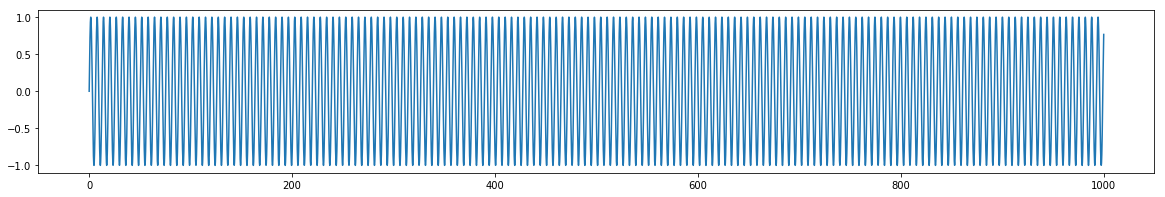

In [0]:
from math import sin
x=np.arange(0,1000,0.1)
y=[sin(m) for m in x]
plt.figure(figsize=(20,3))
plt.plot(x,y)

In [0]:
df=pd.DataFrame({'y':y})
scaler=preprocessing.MinMaxScaler()
df.describe()

,y
count,10000.000000
mean,0.000396
std,0.706954
min,-1.000000
25%,-0.705546
50%,0.002205
75%,0.707410
max,1.000000


In [0]:
df=df.interpolate()

In [0]:
n_feature=1
epochs=50
batch_size=32
back_step=10
forward_step=15
model,train_X,train_y,test_X,test_y=train(df,n_feature=n_feature,batch_size=batch_size,back_step=back_step,forward_step=forward_step,epochs=epochs)#,model=best_model)

          y
0  0.000000
1  0.099833
2  0.198669
3  0.295520
4  0.389418
shape X, y :  (9976, 10, 1) (9976, 1) [[0.5       ]
 [0.54991671]
 [0.59933467]
 [0.6477601 ]
 [0.69470917]
 [0.73971277]
 [0.78232124]
 [0.82210884]
 [0.85867805]
 [0.89166345]] [0.83773159]
test x,y and train x, y shape :  (1024, 10, 1) (1024, 1) (7936, 10, 1) (7936, 1)
train_X[:10],train_y[:10] :  [[[0.5       ]
  [0.54991671]
  [0.59933467]
  [0.6477601 ]
  [0.69470917]
  [0.73971277]
  [0.78232124]
  [0.82210884]
  [0.85867805]
  [0.89166345]]

 [[0.54991671]
  [0.59933467]
  [0.6477601 ]
  [0.69470917]
  [0.73971277]
  [0.78232124]
  [0.82210884]
  [0.85867805]
  [0.89166345]
  [0.92073549]]

 [[0.59933467]
  [0.6477601 ]
  [0.69470917]
  [0.73971277]
  [0.78232124]
  [0.82210884]
  [0.85867805]
  [0.89166345]
  [0.92073549]
  [0.94560368]]

 [[0.6477601 ]
  [0.69470917]
  [0.73971277]
  [0.78232124]
  [0.82210884]
  [0.85867805]
  [0.89166345]
  [0.92073549]
  [0.94560368]
  [0.96601954]]

 [[0.69470917]
  [

In [0]:
# Save entire model to a HDF5 file
model.save('/content/gdrive/My Drive/Colab Notebooks/my_model.h5')

# Recreate the exact same model, including weights and optimizer.
model = tf.keras.models.load_model('/content/gdrive/My Drive/Colab Notebooks/my_model.h5')

In [0]:
model

plot for error vs epoch


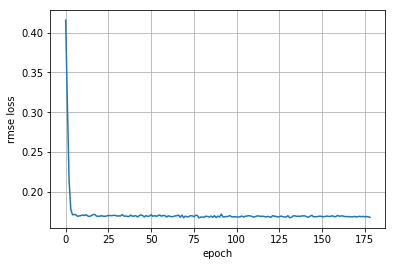

minumum loss: 0.16713613121307525 
at epoch : (array([78]),)
======================================for 10,000data points===========================================================
================================below best_model_graph is for back_step=1,forward_step=15=============================
128/128 [==============================] - 0s 2ms/sample - loss: 0.0273 - mean_absolute_error: 0.1472
[0.027322535403072834, 0.14716111]


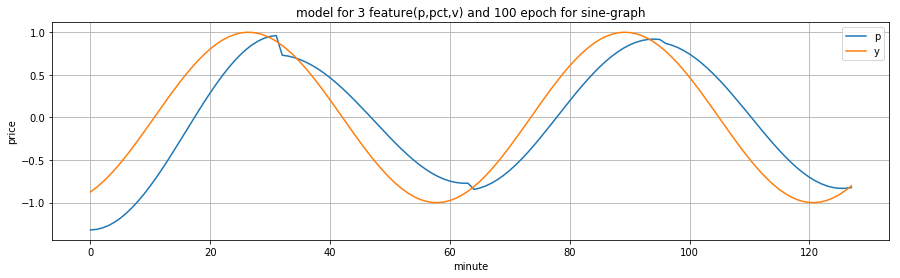

df_yp.describe for initial 500 minute test data
                p           y        diff
count  128.000000  128.000000  128.000000
mean    -0.048047   -0.015308    0.032739
std      0.666324    0.712365    0.394253
min     -1.320198   -0.999735   -0.514496
25%     -0.660842   -0.730993   -0.338563
50%     -0.050042   -0.029194   -0.001869
75%      0.582689    0.689924    0.371354
max      0.961206    0.999827    0.739114


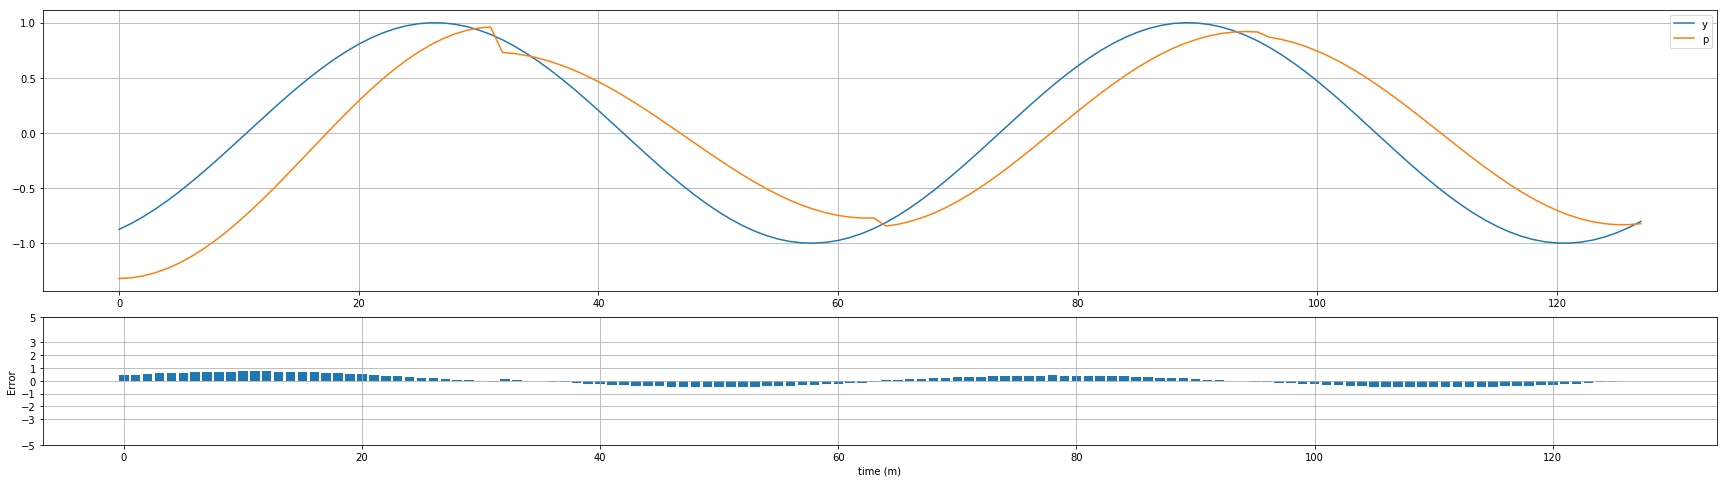

Root Mean Square Error on test set: 0.165


In [0]:
ticker='sine-graph'
_=plot_graph(model)
print('======================================for 1,000data points===========================================================')
print('================================below best_model_graph is for back_step=1,forward_step=5=============================')
best_model = tf.keras.models.load_model('best_model.h5')
pred = best_model.predict(test_X, batch_size=batch_size)
loss_and_metrics = best_model.evaluate(test_X,test_y, batch_size=batch_size)
print(loss_and_metrics)
_=plot_graph(best_model,pred=pred,test_y=test_y,best_model_bool=True)
rmse = np.sqrt(loss_and_metrics[0])
print('Root Mean Square Error on test set: {}'.format(round(rmse, 3)))

In [0]:
# print(train_X[:20],train_y[:20])#checked
'''
why initial prediction is poor but it got good after 70data points
'''

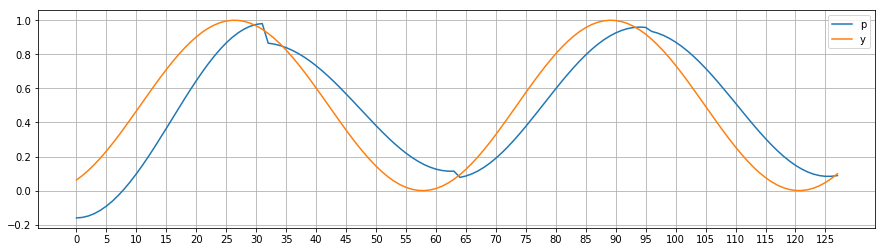

In [0]:
plt.figure(figsize=(15,4))
plt.plot(pred[:150],label='p')
plt.plot(test_y[:150],label='y')
plt.xticks(ticks=[m for m in range(len(pred[:150])) if m%5==0],)
plt.grid()
plt.legend()

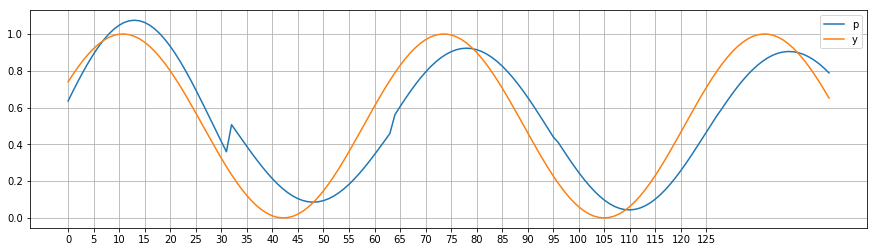

In [0]:
pred_train=best_model.predict(train_X,batch_size=batch_size)
plt.figure(figsize=(15,4))
plt.plot(pred_train[:150],label='p')
plt.plot(train_y[:150],label='y')
plt.xticks(ticks=[m for m in range(len(pred[:150])) if m%5==0],)
plt.grid()
plt.legend()

plot for error vs epoch


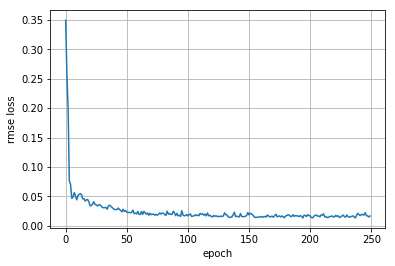

minumum loss: 0.013420659858333291 
at epoch : (array([194]),)
======================================for 10,000data points===========================================================
================================below best_model_graph is for back_step=1,forward_step=15=============================
96/96 [==============================] - 0s 4ms/sample - loss: 3.1512e-04 - mean_absolute_error: 0.0141
[0.00031511760850359377, 0.014143922]


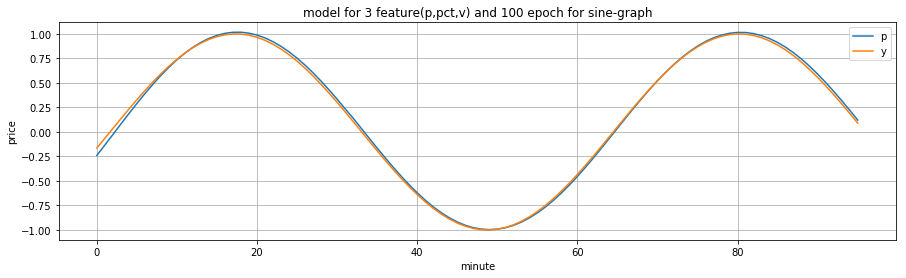

df_yp.describe for initial 500 minute test data
               p          y       diff
count  96.000000  96.000000  96.000000
mean    0.212276   0.205949  -0.006327
std     0.680598   0.673429   0.024331
min    -0.996771  -0.999735  -0.033957
25%    -0.360520  -0.351536  -0.026062
50%     0.364532   0.362295  -0.011559
75%     0.831392   0.819949   0.008490
max     1.017028   0.999827   0.075558


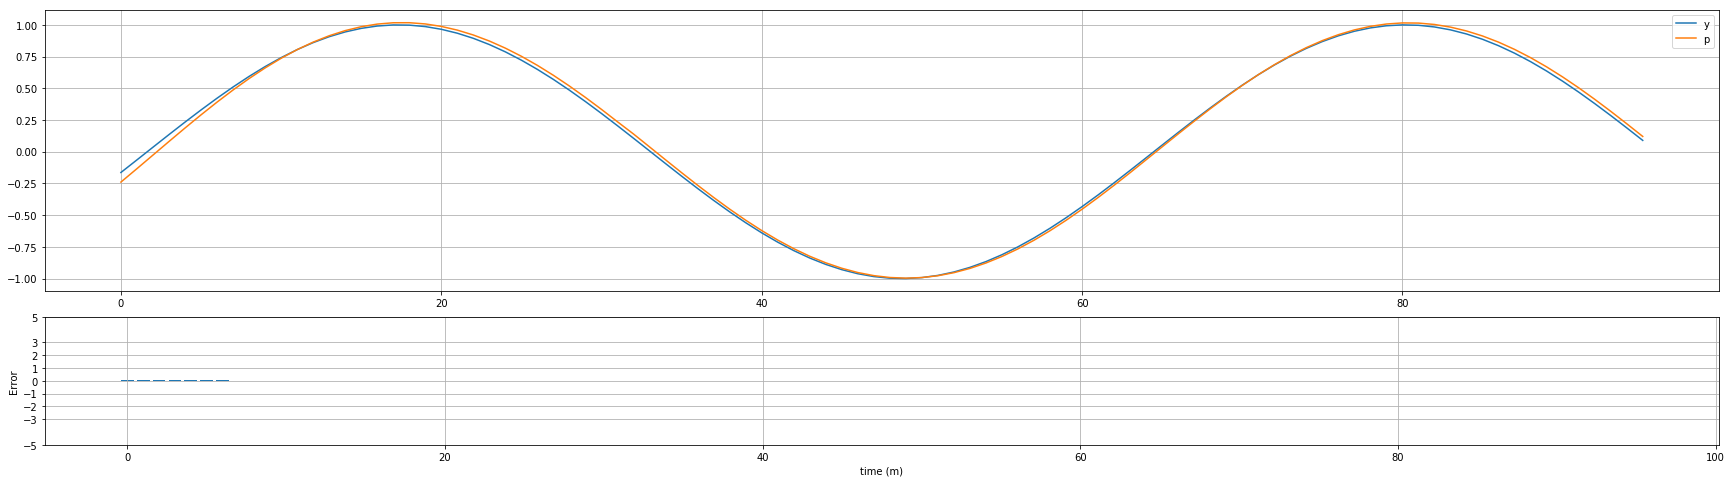

Root Mean Square Error on test set: 0.018


In [0]:
ticker='sine-graph'
_=plot_graph(model)
print('======================================for 1,000data points===========================================================')
print('================================below best_model_graph is for back_step=10,forward_step=5=============================')
best_model = tf.keras.models.load_model('best_model.h5')
pred = best_model.predict(test_X, batch_size=batch_size)
loss_and_metrics = best_model.evaluate(test_X,test_y, batch_size=batch_size)
print(loss_and_metrics)
_=plot_graph(best_model,pred=pred,test_y=test_y,best_model_bool=True)
rmse = np.sqrt(loss_and_metrics[0])
print('Root Mean Square Error on test set: {}'.format(round(rmse, 3)))

plot for error vs epoch


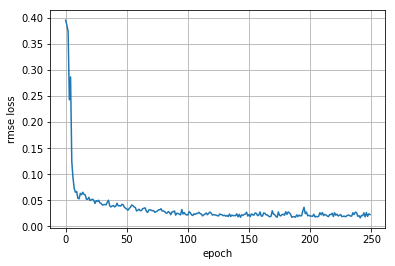

minumum loss: 0.016314757431262265 
at epoch : (array([241]),)
======================================for 1,000data points===========================================================
================================below best_model_graph is for back_step=10,forward_step=15=============================
96/96 [==============================] - 0s 5ms/sample - loss: 0.0014 - mean_absolute_error: 0.0246
[0.0014268970044213347, 0.024610152]


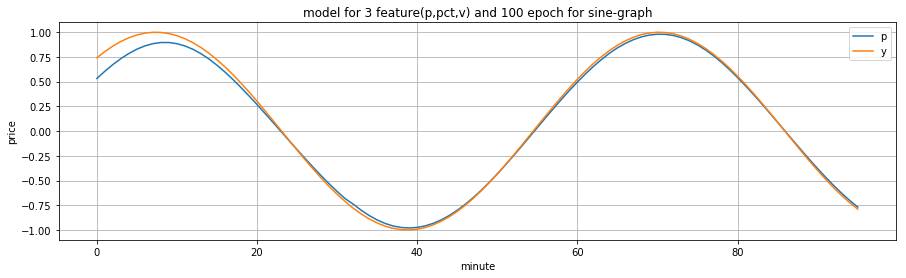

df_yp.describe for initial 500 minute test data
               p          y       diff
count  96.000000  96.000000  96.000000
mean    0.111043   0.133400   0.022357
std     0.664039   0.699201   0.052442
min    -0.980208  -0.999735  -0.040610
25%    -0.521502  -0.530476  -0.013107
50%     0.205422   0.227142   0.014933
75%     0.740307   0.819949   0.027994
max     0.979901   0.999827   0.209495


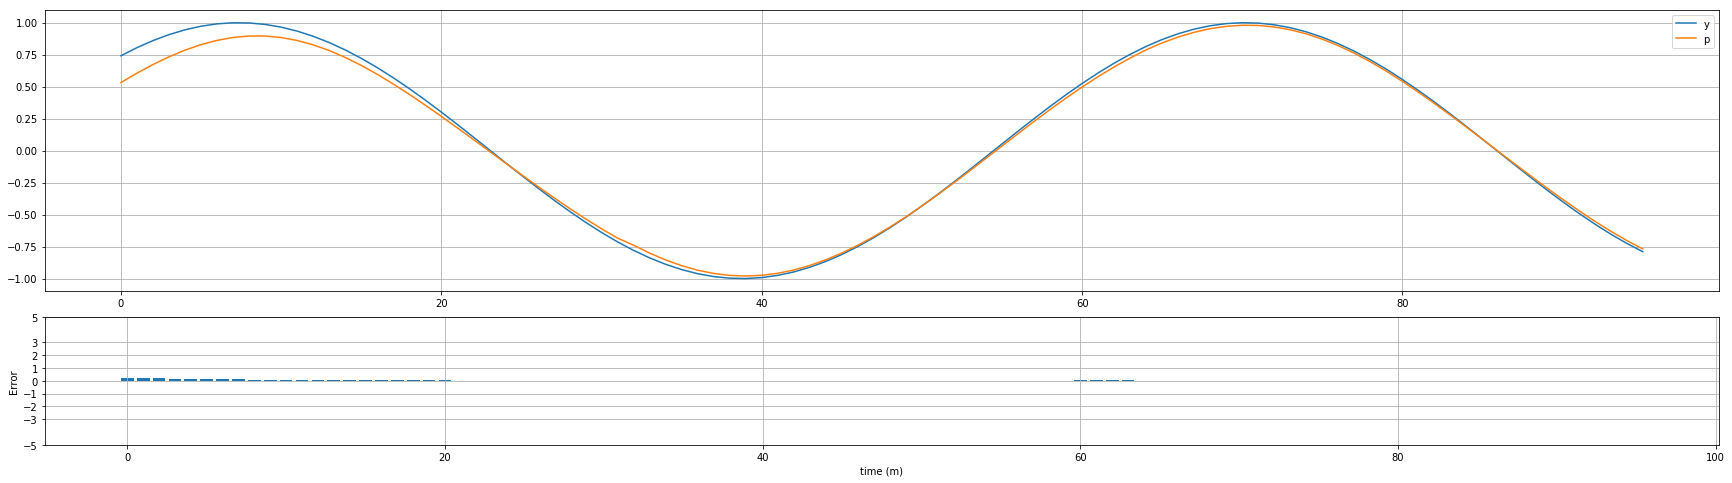

Root Mean Square Error on test set: 0.038


In [0]:
ticker='sine-graph'
_=plot_graph(model)
print('======================================for 1,000data points===========================================================')
print('================================below best_model_graph is for back_step=10,forward_step=15=============================')
best_model = tf.keras.models.load_model('best_model.h5')
pred = best_model.predict(test_X, batch_size=batch_size)
loss_and_metrics = best_model.evaluate(test_X,test_y, batch_size=batch_size)
print(loss_and_metrics)
_=plot_graph(best_model,pred=pred,test_y=test_y,best_model_bool=True)
rmse = np.sqrt(loss_and_metrics[0])
print('Root Mean Square Error on test set: {}'.format(round(rmse, 3)))

plot for error vs epoch


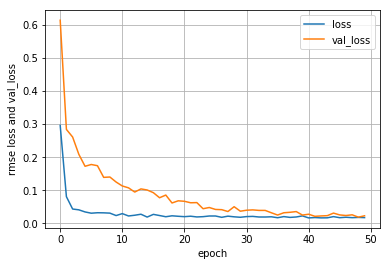

minumum loss: 0.016458978993877042 
at epoch : (array([40]),)
minumum val_loss: 0.018750291358498764 
at epoch : (array([48]),)
======================================for 10,000data points===========================================================
================================below best_model_graph is for back_step=10,forward_step=15=============================
1024/1024 [==============================] - 1s 1ms/sample - loss: 1.4136e-04 - mean_absolute_error: 0.0101
[0.00014136196773506526, 0.010091586]


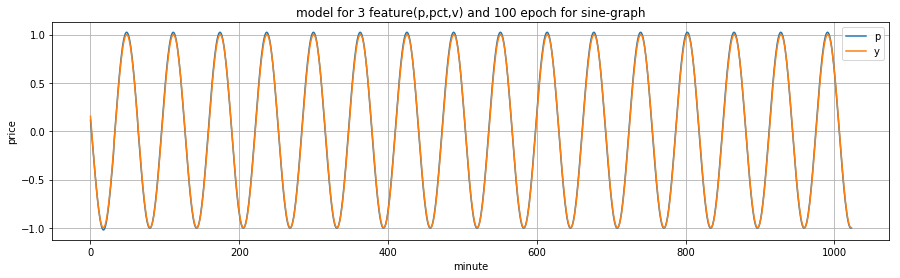

df_yp.describe for initial 500 minute test data
                p           y        diff
count  500.000000  500.000000  500.000000
mean     0.004990   -0.001749   -0.006740
std      0.719413    0.709266    0.020419
min     -1.021841   -0.999976   -0.033149
25%     -0.709703   -0.705710   -0.026541
50%     -0.000992   -0.003982   -0.010412
75%      0.729570    0.711953    0.014511
max      1.024602    1.000000    0.039200


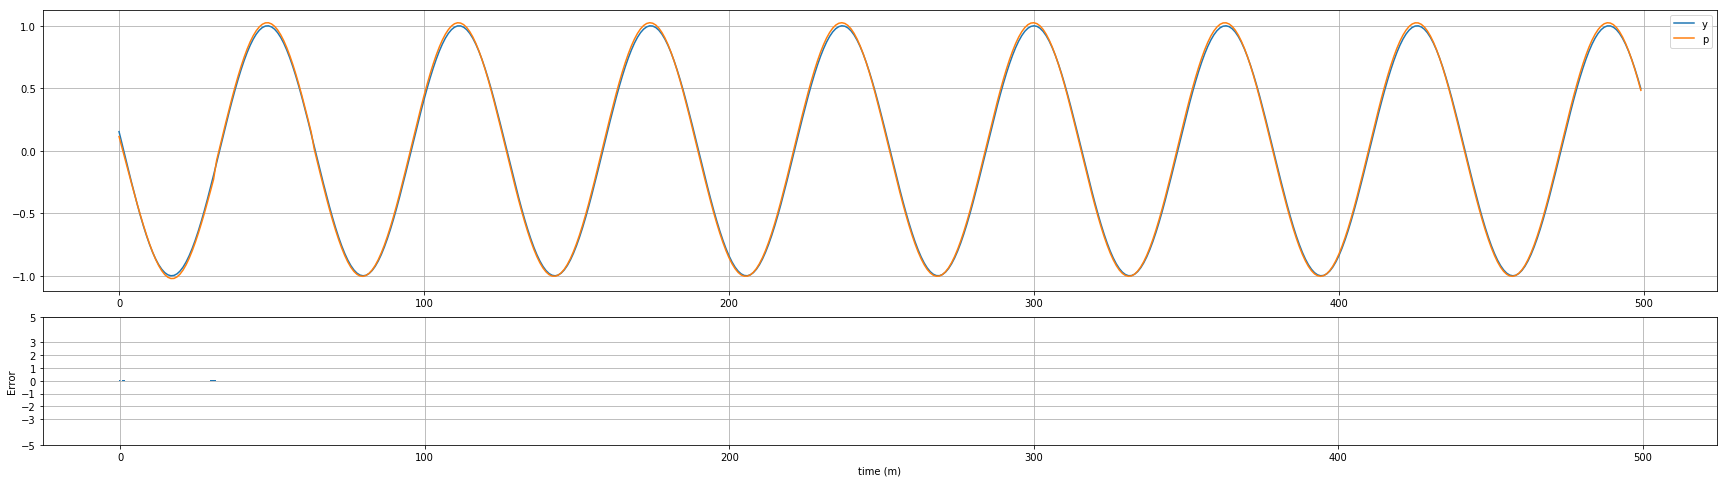

Root Mean Square Error on test set: 0.012


In [0]:
ticker='sine-graph'
_=plot_graph(model)
print('======================================for 10,000data points===========================================================')
print('================================below best_model_graph is for back_step=10,forward_step=15=============================')
best_model = tf.keras.models.load_model('best_model.h5')
pred = best_model.predict(test_X, batch_size=batch_size)
loss_and_metrics = best_model.evaluate(test_X,test_y, batch_size=batch_size)
print(loss_and_metrics)
_=plot_graph(best_model,pred=pred,test_y=test_y,best_model_bool=True)
rmse = np.sqrt(loss_and_metrics[0])
print('Root Mean Square Error on test set: {}'.format(round(rmse, 3)))